# Week 3, Data science in Neuroscience

## Plan for today

1. Quick review of our electrophysiological data.
2. Why and how are in-vivo recordings performed?
3. Detecting action potentials (spikes) from raw extracellular recordings and spike clustering
    * Filtering out unwanted frequencies from signals (1st session)
    * Detecting spike events in the filtered signals (1st session)
    * Extracting spike waveforms from raw signals (2nd session)
    * Dimensionality reduction of spike waveforms (3rd session)
    * Clustering spike waveforms (3rd session)
***

Next week, there is no lecture on Thursday. We will complete this part of the course next Friday.
***

## Review of our electrophysiological data

Reload the data from week 1.

This is a recording from 8 electrodes/channels for 1 second at 20 000 Hz.


After completing the exercises, you should now know that the array looks like the one in this figure.
<div>
<img src="../images/array.png" width="600"/>
</div>



In [12]:
import numpy as np
import matplotlib.pyplot as plt

fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

In [13]:
dat

array([[ -441,  -357,  -314, ...,  -430,  -478,  -417],
       [ -270,  -331,  -291, ...,  -229,  -135,  -168],
       [ -707,  -747,  -657, ...,  -775,  -660,  -698],
       ...,
       [ -752,  -600,  -619, ...,  -600,  -701,  -727],
       [-1060,  -796,  -906, ...,  -966, -1129, -1232],
       [-1226,  -956,  -881, ...,  -871,  -914,  -976]], dtype=int16)

## Exercises

Here are some of the exercises from Week 1. 

Can we still answer them?

* How many dimensions does the data have?
* What is the size of the array in each dimension?
* What is the data type or dtype (integer, float, etc.) of the `dat` array?
* Which dimension represents the recording channels and the recording samples?

In [17]:
dat.shape

(8, 20000)

* Plot the data for the first recording channel.
* Plot the data for 2 recording channels. 

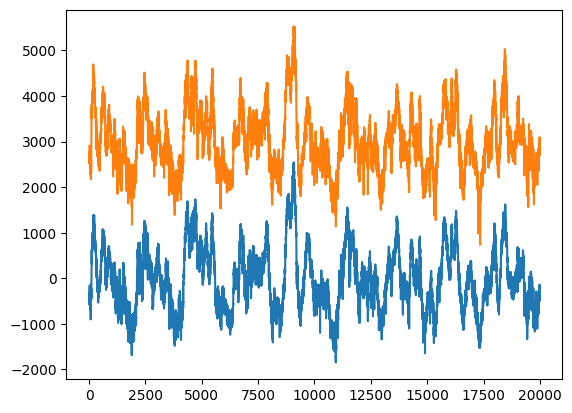

In [21]:
plt.plot(dat[0,:])
plt.plot(dat[1,:]+3000)
plt.show()

* What is the mean value in the `dat` array?
* What is the mean value per channel of the `dat` array?
* How could I add 100 to all values in the array?
* Which channel has the largest standard deviation?

In [24]:
dat+100

array([[ -341,  -257,  -214, ...,  -330,  -378,  -317],
       [ -170,  -231,  -191, ...,  -129,   -35,   -68],
       [ -607,  -647,  -557, ...,  -675,  -560,  -598],
       ...,
       [ -652,  -500,  -519, ...,  -500,  -601,  -627],
       [ -960,  -696,  -806, ...,  -866, -1029, -1132],
       [-1126,  -856,  -781, ...,  -771,  -814,  -876]], dtype=int16)

***

# Why and how are in-vivo recordings performed?

**Aim:** Monitor the activity of groups of neurons during behavior. 

The correlations between cell activity and behavior inform us about the potential role of a brain area for behavior. We can learn how information is processed within neuronal circuits. The effect of different manipulations (optogenetics, pharmacology) on network activity can be assessed.

## Example: Spatially selective neurons in the medial entorhinal cortex (MEC)

By recording the activity of neurons in the entorhinal cortex in freely-moving mice, scientists discovered that some neurons in the medial entorhinal cortex encode where the animal is in its environment and in which direction it is heading. This brain region is essential for navigation.


<div>
<img src="../images/mec_neurons.png" width="400"/>
</div>

* Left column: Spikes (red) on top of the path of the animal (black).
* Right column: Firing rate of the neuron as a function of position (top), head-direction (middle) and running speed (bottom). 


<div>
<img src="../images/Nobel.jpg" width="400"/>
</div>
These 3 fellows won the Nobel Prize for their discovery of place and grid cells.



### References
* Hafting et al., 2005. Microstructure of a spatial map in the entorhinal cortex. Nature
* Sargolini et al., 2006. Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex. Nature
* Gil et al., 2018. Impaired path integration in mice with disrupted grid cell firing. Nature Neuroscience

## Electrodes -> Amplifier -> Digitalization -> Recording on disk

Electrodes located in the extracellular space can pick up action potentials (sharp negative fluctuation in voltage) from several neurons. 

<div>
<img src="../images/buzsaki_tetrode_in_layer.jpg" width="600"/>
</div>


<div>
<img src="../images/buzsaki_probe.webp" width="800"/>
</div>

<div>
<img src="../images/intan_64.jpg" width="300"/>
</div>


### References
* Buzsaki, 2004. Large-scale recording of neuronal ensembles. Nature Neuroscience
* Steinmetz et al., 2021. Neuropixels 2.0: A miniaturized high-density probe for stable, long-term brain recordings. Science
* https://intantech.com/


The recording system sample the voltage on multiple channels at 20-30 kHz. The amplified signal is saved to disk for later analysis.

***

# Spike extraction and clustering


We want to study the activity (action potentials) of single neurons. We need to find at which time which neurons fired action potentials from our raw recordings. 

Assumptions:
1. All the spikes from one neuron will have a constant waveform shape on the different channels. The pattern across the different channels depend on the proximity of the neuron to the different electrodes (channels).
2. The spike waveform of different neurons will be different because of their different locations relative to the recording sites.

Let's have a look at our data.

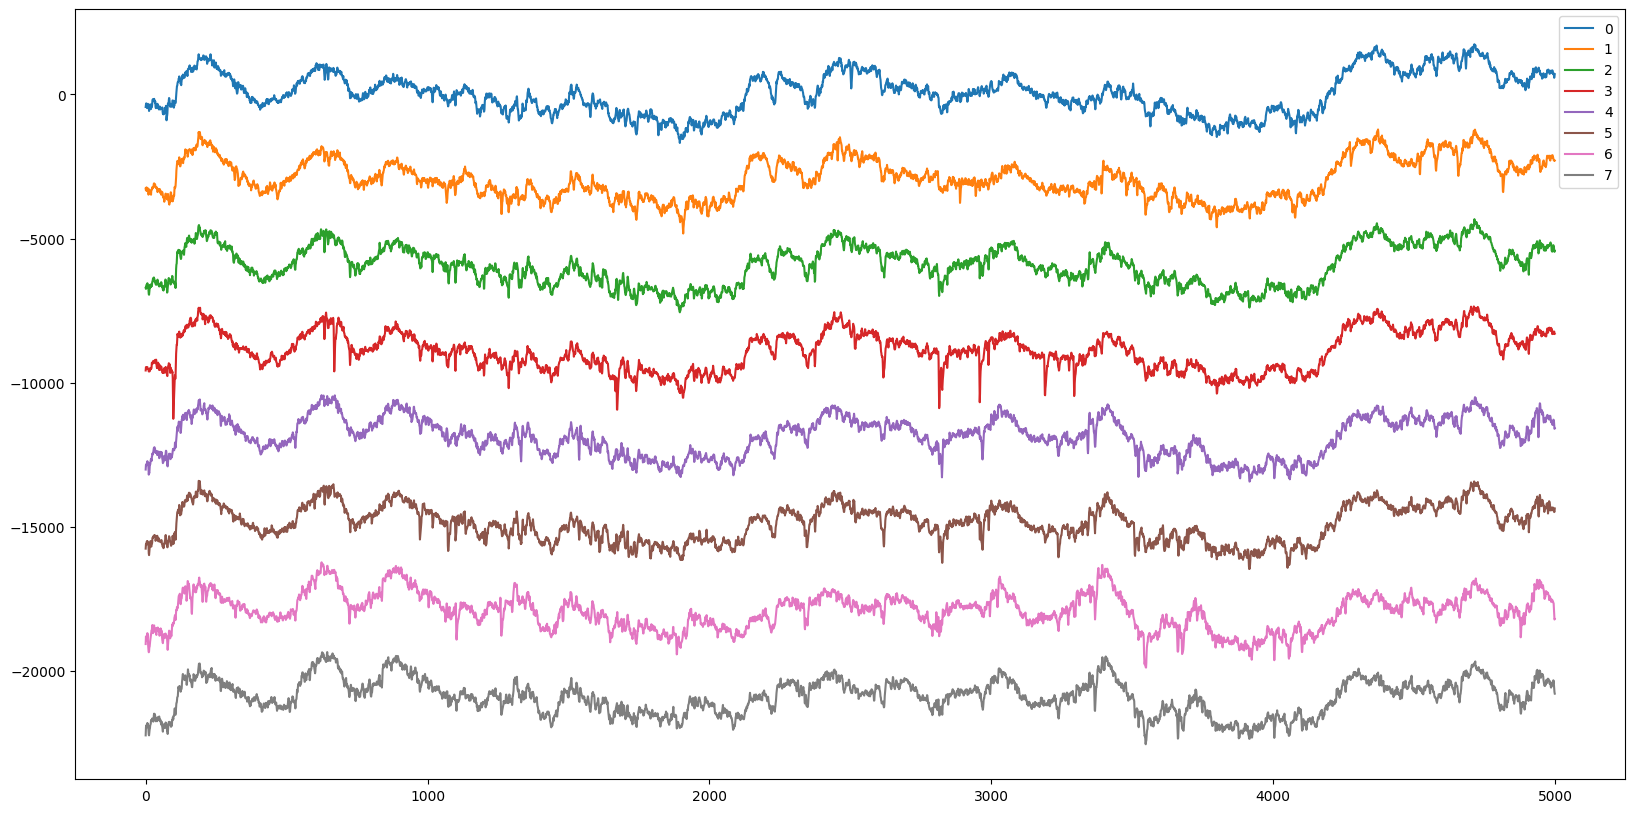

In [26]:
offset=3000 #y-shift between channels when plotting the data
nSamples=5000
plt.figure(figsize=(20,10)) # set the size of the figure

for i in range(dat.shape[0]): #loop for every channel
    plt.plot(dat[i,:nSamples]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
plt.legend()
plt.show()

## Steps involved
* Filtering
* Identifying spikes
* Extracting spike waveforms
* Dimensionality reduction
* Clustering spike waveforms

Note: In the lab, you would normally use an established software package to do this (Kilosort, Spyking circus, etc.).

The main objectives in this part of the course are

* Get more familiar with classic data processing concepts (filtering, dimensionality reduction, clustering).
* Implement these ideas in Python.
* Gain experience using NumPy arrays.
* Learn how to organize your code into functions.

***



<div>
<img src="../images/scipy.png" width="100"/>
</div>



SciPy is a collection of mathematical algorithms and convenience functions built on NumPy. 
It adds significant power to Python by providing the user with high-level commands and classes for manipulating and visualizing data.

We will use functions from the SciPy library for many steps. The documentation for each function is usually very good. 

It contains several classical statistical tests (e.g., t-test, Pearson correlation, Mann-Whitney test)(https://docs.scipy.org/doc/scipy/reference/stats.html)

*** 
## Filtering

The signal recorded is the sum of several components: 

1. Large amplitude spikes of a few neurons close to the recording sites
2. Small amplitude spikes of many distant neurons
3. Fluctuations in synaptic currents onto thousands of neurons (part of local field potentials)
4. Electrical noise from electrical equipment (usually 50 Hz)
5. Head muscle contractions (e.g., noise associated with chewing)

If a neuron is close enough to our electrodes, its action potentials create rapid (usually) negative deflections in the signal. The spikes in extracellular space last less than 1 ms.

To extract action potentials, we need to **separate the fast negative deflections from other slower components of the signal**. That is why we need to filter the signal.

https://docs.scipy.org/doc/scipy/reference/signal.html

https://docs.scipy.org/doc/scipy/tutorial/signal.html


### Create a Butterworth filter

I chose to use a Butterworth filter based on information from research articles in this field of research. 

We eliminate/reduce low-frequency oscillations (below 300 Hz) and keep faster oscillations (including spikes). This is called a `highpass filter` (as opposed to `lowpass` and `bandpass`).



In [27]:
from scipy.signal import butter

In [28]:
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Function to create a Butterworth filter using scipy.signal.butter()
    
    Arguments:
    lowcut: low cut frequency in Hz
    fs: sampling rate in Hz
    order: order of the fitler
    
    Returns
    nth-order sections representation of the IIR filter. 
    
    For more information, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


In [ ]:
fs = 20000 # sampling rate, or samples per seconds, this is in Hz.
lowcut=300 # lowest frequency that will remain in our signal, 300 Hz
myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)

numpy.ndarray

### Display the frequency response of the filter

This step is just to show you the frequencies that will remain after we apply our filter.

Don't worry about the code here.

It should be near 0 and flat at the frequencies that you want to keep, and below 0 for frequencies that you want to filter out.

In [34]:
# calculate the frequency response of our filter for visualization
from scipy.signal import sosfreqz
w, h = sosfreqz(myFilter, worN=1500)

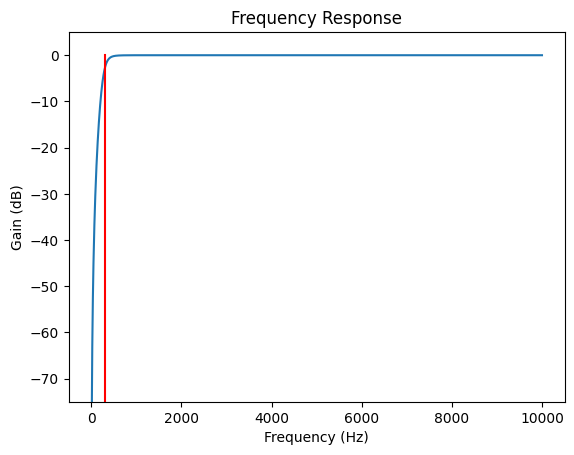

In [35]:
db = 20*np.log10(np.maximum(np.abs(h), 1e-5)) # don't worry about this, transforms h to dB unit
plt.plot(w/np.pi*fs/2, db) # first part transform w to in Hz unit
plt.ylim(-75, 5)
plt.ylabel('Gain (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')
plt.plot([lowcut,lowcut],[-75,0],c="red")
plt.show()

## Apply the fitler to a recording channel

We can apply our filter with `sosfiltfilt()`. We use `sosfiltfilt()` over `sosfilt()` to avoid change in phase.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html

See also https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

In [36]:
from scipy.signal import sosfiltfilt
chan=3
y = sosfiltfilt(myFilter, dat[chan,:]) # we filter the raw data from channel 3 and save the results in y
print(y.shape, dat[chan,:].shape) # y has same shape as the raw data from channel 3

(20000,) (20000,)


Plot the raw and filtered signals

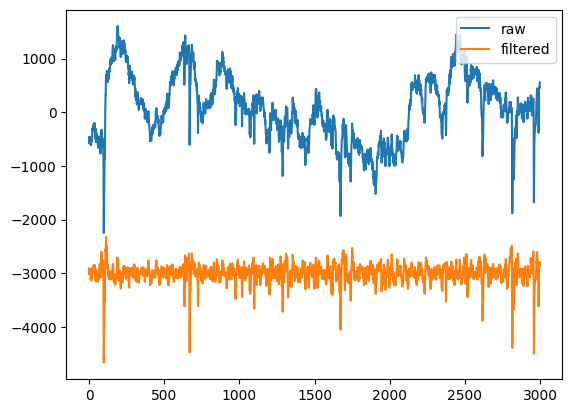

In [46]:
nSamples=3000
plt.plot(dat[chan,:nSamples],label="raw")
plt.plot(y[:nSamples]-3000,label="filtered")
plt.legend(loc="upper right")
plt.show()

Plot fewer data points to zoom in on the raw and filtered signals. 

## Exercises: 

* Try to apply the filter to the 8 recording channels. 
* How could you store/save the filtered data for each channel.



In [30]:
chan = 3
y = sosfiltfilt(myFilter, dat[chan,:]) 

In [67]:
a = sosfiltfilt(myFilter, dat[i,:]) # filter the data from channel i
a.dtype

dtype('float64')

In [72]:
yy = np.empty(dat.shape)
yy.dtype, yy.shape

(dtype('float64'), (8, 20000))

In [70]:
yy = np.zeros_like(dat,dtype=np.float32) # create an empty array of the same size as dat
for i in range(dat.shape[0]):
    yy[i] = sosfiltfilt(myFilter, dat[i,:]) # filter the data from channel 
yy

array([[ -31.941637 ,   51.863934 ,   94.320564 , ...,  -63.739952 ,
        -100.53817  ,  -27.14921  ],
       [  11.782912 ,  -47.520927 ,   -6.00014  , ..., -121.359985 ,
         -19.881632 ,  -44.201054 ],
       [ -42.83561  ,  -80.37578  ,   11.48427  , ..., -139.57289  ,
          -8.330638 ,  -28.835321 ],
       ...,
       [ -51.448853 ,   97.632866 ,   74.95489  , ...,   55.395752 ,
         -25.224384 ,  -29.835348 ],
       [ -63.09269  ,  197.5004   ,   83.067215 , ...,  249.27374  ,
         105.874054 ,   22.902035 ],
       [ -48.81082  ,  205.1067   ,  263.26816  , ...,   66.66775  ,
          38.76013  ,   -7.2846212]], dtype=float32)

In [62]:
yy

array([[ -31,   51,   94, ...,  -63, -100,  -27],
       [  11,  -47,   -6, ..., -121,  -19,  -44],
       [ -42,  -80,   11, ..., -139,   -8,  -28],
       ...,
       [ -51,   97,   74, ...,   55,  -25,  -29],
       [ -63,  197,   83, ...,  249,  105,   22],
       [ -48,  205,  263, ...,   66,   38,   -7]], dtype=int16)

In [74]:
yy = sosfiltfilt(myFilter, dat) # filter all the channels at once

In [75]:
yy

array([[ -31.9416374 ,   51.86393326,   94.32056133, ...,  -63.7399531 ,
        -100.53816968,  -27.14921022],
       [  11.78291257,  -47.52092817,   -6.00014013, ..., -121.35998687,
         -19.88163099,  -44.20105445],
       [ -42.83560898,  -80.37577991,   11.48427031, ..., -139.57288444,
          -8.33063755,  -28.8353213 ],
       ...,
       [ -51.44885337,   97.63286381,   74.95488498, ...,   55.39575235,
         -25.22438448,  -29.83534751],
       [ -63.09268971,  197.50039168,   83.0672128 , ...,  249.27374068,
         105.87405515,   22.9020348 ],
       [ -48.81082118,  205.10671048,  263.26816803, ...,   66.66774872,
          38.76013273,   -7.2846213 ]])

As always, don't just assume that the filter was applied to all channels, plot the data to be sure.

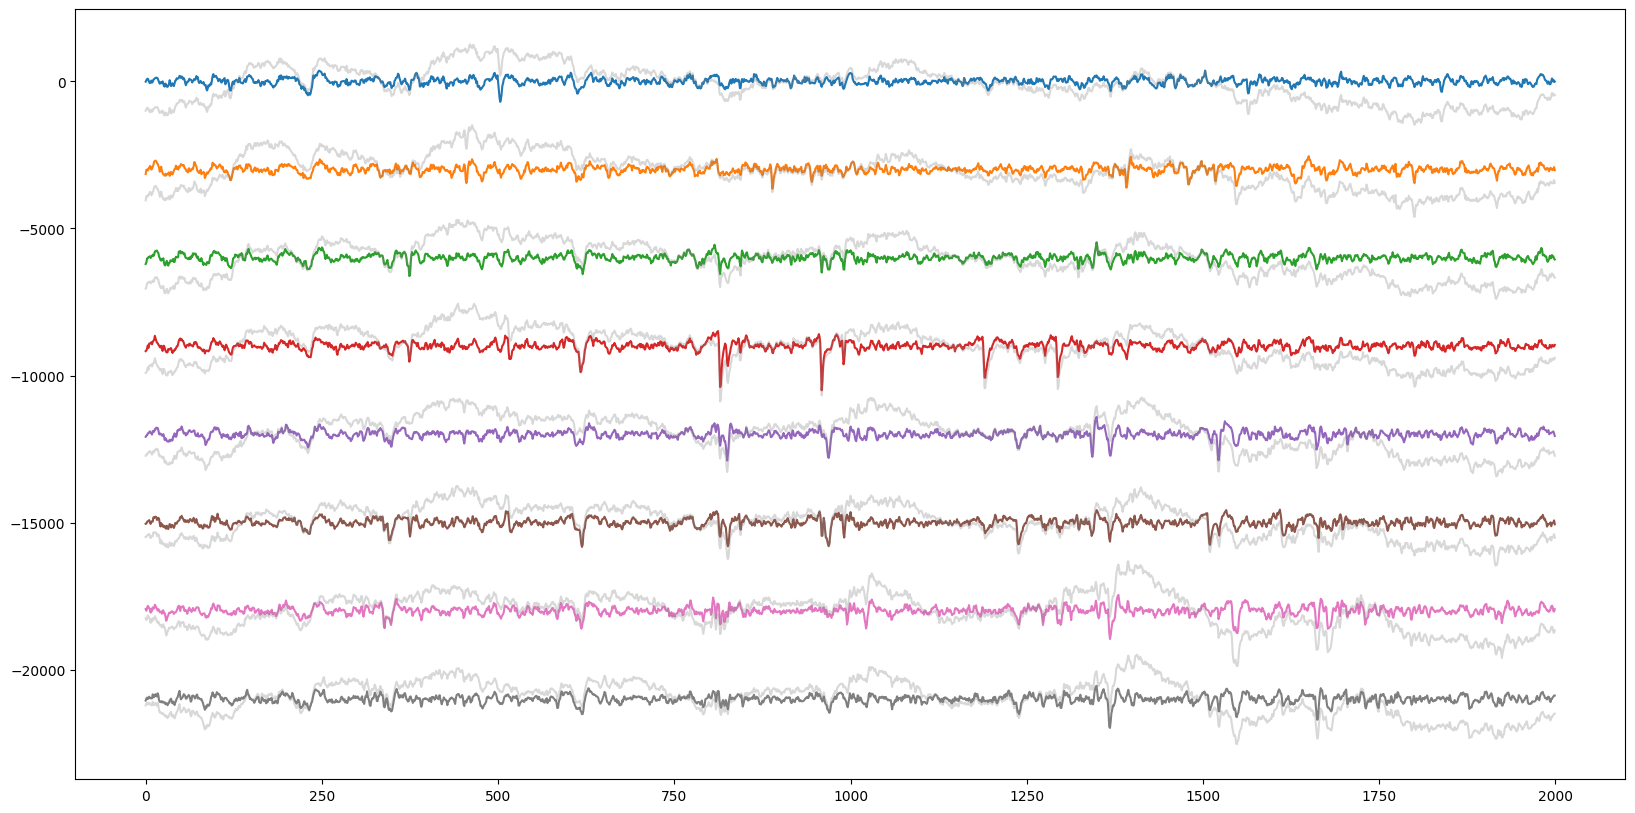

In [76]:
offset=3000
plt.figure(figsize=(20,10))
for i in range(yy.shape[0]):
    plt.plot(yy[i,2000:4000]-offset*i)
    plt.plot(dat[i,2000:4000]-offset*i,color="gray",alpha=0.3)
plt.show()

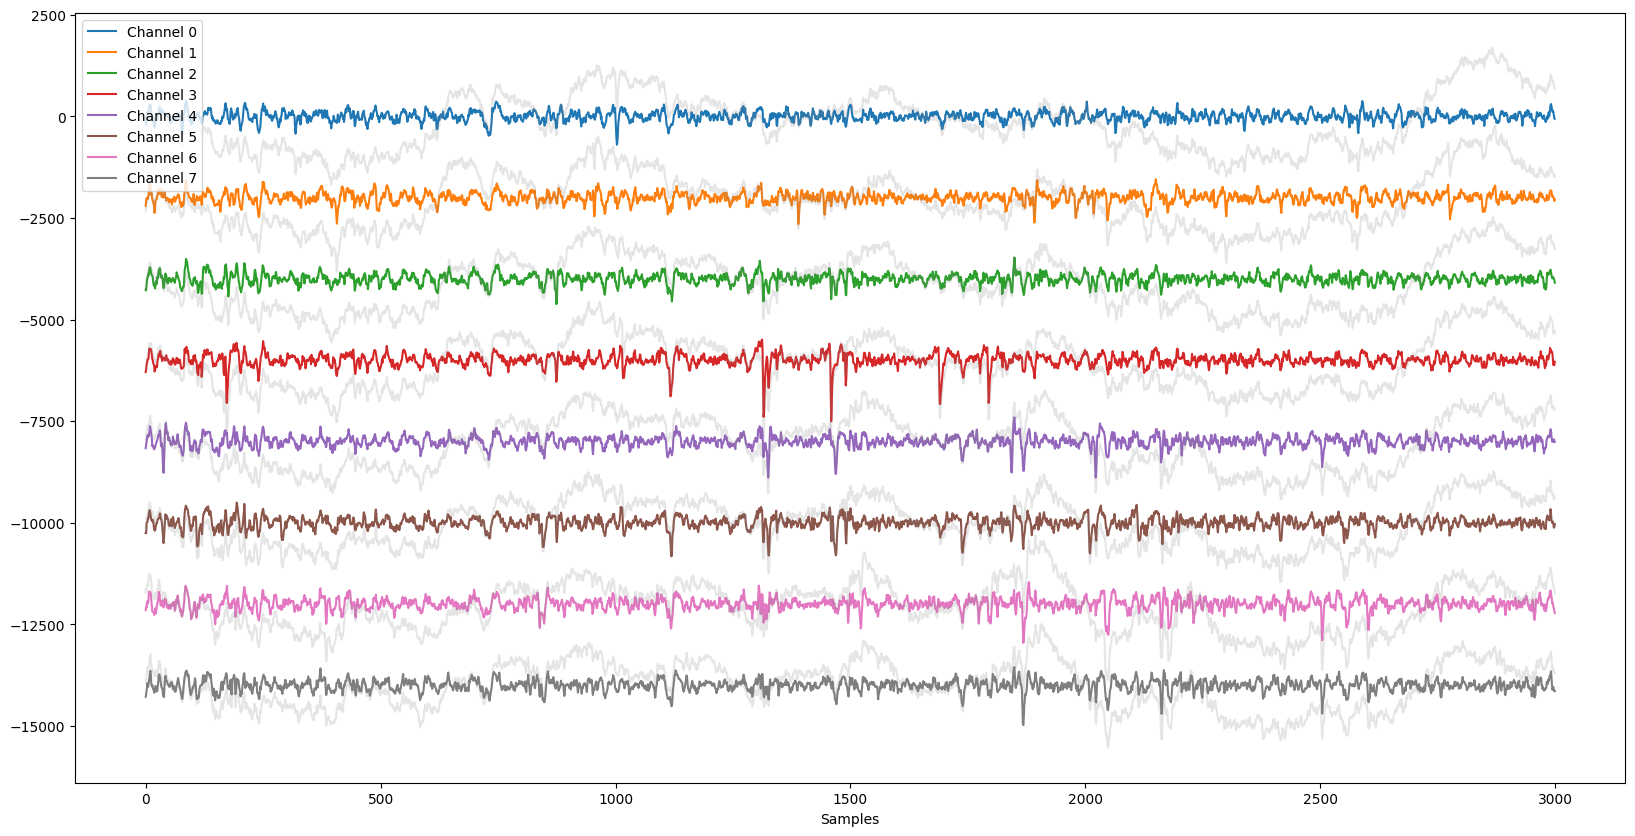

In [77]:
offset=2000 #y shift on the y-axis between channels
startSample=1500
nSamples=3000
nChannels=8
plt.figure(figsize=(20,10))

for i in range(nChannels): #loop for every channel
    yAxisOffset=i*offset # to avoid plotting all channels on top of each other, channel 0 will be at the top
    plt.plot(yy[i,startSample:startSample+nSamples]-yAxisOffset,label="Channel {}".format(i),alpha=1) # plot the filtered data
    plt.plot(dat[i,startSample:startSample+nSamples]-yAxisOffset,c="gray",alpha=0.2) # plot original signal in transparent gray
plt.legend(loc="upper left")
plt.xlabel("Samples")

fn = "filteredSignals.png"
plt.savefig(fn)

***
## Detecting spikes

We have removed slow owcillations from the raw signal. We can try to identify spikes in the filtered signal.

One simple strategy is to calculate the **mean** and **standard deviation** of the filtered signal. A spike occures each time the signal reaches 5 standard deviation below the mean. This is the __spike detection threshold__.


Steps:

* Calculate mean and standard deviation
* Calculate the spike detection threshold
* Detect the events that reached the spike detection threshold

### Calculating the mean and standard deviation

We will use a single channel (chan=3) to simplify the problem.


### Exercise

* Calculate and print the mean and standard deviation of channel indexed 3

In [80]:
channel_mean = yy[3].mean()
channel_std = yy[3].std()

print("Standard deviation", channel_std)
print("Mean", channel_mean)


Standard deviation 140.0146706903993
Mean 0.040036583062989094


* Calculate the spike detection threshold

In [83]:
threshold = channel_mean - 5*channel_std
threshold

np.float64(-700.0333168689335)

* Plot the data to check if this makes sense.

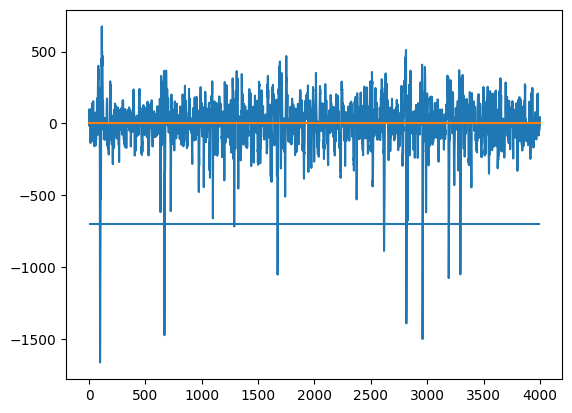

In [87]:
plt.plot(yy[3,0:4000])
plt.hlines(threshold,0,4000)
plt.plot([0,4000],[channel_mean,channel_mean])

***
# Summary

After this session, you should  

* Be able to filter raw 1D signals using SciPy.
* Be more familiar with manipulating NumPy arrays (slicing, using methods like .mean(), .std(), broadcasting, etc.).
* Know that anyone good at data science is plotting its data all the time.
